# <span style="color:#bcff8f"> Week 8 Assignment</span>

<span style="font-size:12pt;color:gray;font-weight:bold"> Patrick Weatherford</span><br>

<span style="font-size:16pt">Hypothesis Testing & Linear Least Squares</span>

***
http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

***

<br>

Setting working directly to ThinkStats directory and importing modules

In [1]:
import os

# changing working directory to ThinkStats2/code folder
path = os.path.expanduser('~') + '\\OneDrive - Bellevue University\\Bellevue_University\\DSC 530 - Data Exploration and Analysis\\ThinkStats2\\code'
os.chdir(path)

%matplotlib inline

import thinkstats2 as ts2
import thinkplot as tp
import nsfg
import brfss
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import bisect
import scipy as sp
from matplotlib.offsetbox import (AnchoredOffsetbox, TextArea)
import math
import first



<br><br>

Load data

In [2]:
import first
live, firsts, others = first.MakeFrames()

<br><br>

## Exercise 9-1

As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real. To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame. What happens to the p-values of these tests as the sample size decreases? What is the smallest sample size that yields a positive test?

***

<u>Interpretation</u>: From what it appears, there seems to be a high level of uncertaintity in the p-values when the sample size is small. The p-values seem to jump around all over the place which makes sense because with less data, there is less certainty about how well the sample estimates a population. In retrospect, as the sample size got higher, the randomness of the p-value begins to level out which again makes sense because as you get more data, you become more confident about how the data represents a population. Also, for this particular sample of data, the p-values got slightly lower as the sample size increased.

In [3]:
class HypothesisTest(object):
    
    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        
    def PValue(self, iterations=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) for _ in range(iterations)]
        n = len(self.test_stats)
        self.test_vals, self.test_freq = np.unique(self.test_stats, return_counts=True)
        self.test_prob = self.test_freq / n
        self.test_cdf = np.cumsum(self.test_prob)
        count = sum(1 for x in self.test_stats if x >= self.actual)
        self.p_value = count / iterations
        return self.p_value
    
    def PlotCDF(self, title=None, xlabel=None, ylabel='CDF'):
        cdf_plot = sns.lineplot(x=self.test_vals, y=self.test_cdf)
        ax = plt.gca()
        xmin, xmax, ymin, ymax = plt.axis()
        plt.vlines(x=self.actual, ymin=0, ymax=1, colors='red', alpha=.6)
        plt.title(title)
        box = AnchoredOffsetbox(child=TextArea(f'p-value: {self.p_value}'), loc='lower right' ,frameon=True)
        box.patch.set_boxstyle('square,pad=0')
        ax.add_artist(box)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        return cdf_plot
    
    def TestStatistic(self, data):
        pass
    
    def MakeModel(self):
        pass
        
    def RunModel(self):
        pass
    
    
    
class DiffMeansPermute(HypothesisTest):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)  # call out inheritance of __init__ method from parent class
        
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())  # testing whether there is any difference
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n1, self.n2 = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))  # horizontally stack data into 1 array    
        
    def RunModel(self):
        np.random.shuffle(self.pool)  # randomly shuffle array
        data = self.pool[:self.n1], self.pool[self.n2:]
        return data
    

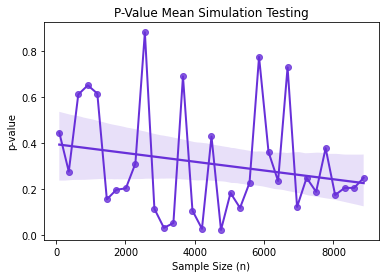

In [4]:
i = .01  # start percent of data to pull

pval_list = []
firsts_n_list = []
others_n_list = []

while i < 1:
    firsts_n = math.floor(len(firsts.prglngth.values) * i)
    firsts_n_list.append(firsts_n)
    others_n = math.floor(len(others.prglngth.values) * i)
    others_n_list.append(others_n)
    
    len_data = np.random.choice(firsts.prglngth.values, size=firsts_n, replace=False), np.random.choice(others.prglngth.values, size=others_n, replace=False)
    
    dmp = DiffMeansPermute(len_data)
    pval_list.append(dmp.PValue())
    
    i += .03
    
x_n = np.asarray(firsts_n_list) + np.asarray(others_n_list)
    
sns.lineplot(x=x_n, y=pval_list, color='#6830d9', linewidth=2)
sns.regplot(x=x_n, y=pval_list, scatter_kws={"color": "#6830d9"}, line_kws={"color": "#6830d9"})
plt.title('P-Value Mean Simulation Testing')
plt.xlabel('Sample Size (n)')
plt.ylabel('p-value')
plt.show()

<br><br>

## Exercise 10-1

Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height? Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?


In [98]:
df = brfss.ReadBrfss()

df = df.dropna(subset=['htm3', 'wtkg2'])

data = df.htm3, df.wtkg2

In [103]:
class LeastSquares(object):
    
    def __init__(self, data):
        self.data = data
        xs, ys = data
        xs, ys = np.asarray(xs), np.asarray(ys)
        sort_i = xs.argsort()
        self.xs = xs[sort_i]
        self.ys = ys[sort_i]
        self.mean_xs, self.var_xs = np.mean(self.xs), np.var(self.xs)
        self.mean_ys, self.var_ys = np.mean(self.ys), np.var(self.ys)
        self.cov = np.dot(self.xs-self.mean_xs, self.ys-self.mean_ys) / len(self.xs)
        self.slope = self.cov / self.var_xs  # slope is shared variance of x & y divided by variance in x
        self.intercept = self.mean_ys - (self.slope * self.mean_xs)

        ## residuals and predicted values
        self.predicted_values = self.intercept + (self.slope * self.xs)
        self.residuals = self.ys - self.predicted_values
        
    def coef_of_determ(self):
        coef_of_determ = 1 - ( np.var(self.residuals) / np.var(self.ys - self.mean_ys) )
        return coef_of_determ
        
    def lm_plot(self, title=None, xlabel=None, ylabel=None, alpha=1, linecolor='red', plotcolor='black'):
        self.lm_ys = []
        lm_xs = np.sort(self.xs)
        n = len(lm_xs)

        for x in lm_xs:
            y = (self.slope*x) + self.intercept
            self.lm_ys.append(y)

        sns.lineplot(x=lm_xs, y=self.predicted_values, linewidth=3, color=linecolor)
        sns.scatterplot(x=self.xs, y=self.ys, alpha=alpha, edgecolor=None, color=plotcolor)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        ax = plt.gca()
        box = AnchoredOffsetbox(child=TextArea(f'Slope: {round(self.slope,3)}\nIntercept: {round(self.intercept,1)}\nr2: {round(self.coef_of_determ(),3)}'), loc='upper left' ,frameon=True)
        box.patch.set_boxstyle('square,pad=0')
        ax.add_artist(box)
        plt.show()
        
        
class DisFunction(object):
    
    def __init__(self, data):
        self.data = np.asarray(data)
        self.size = self.data.size
        self.unique_vals, self.freq = np.unique(self.data, return_counts=True)
        self.pmf = self.freq / self.size
        self.cdf = np.cumsum(self.pmf)
        self.mean = sum(self.data) / self.size
        self.std = np.std(data)
        
    def percentile(self, percentile, method='inverted_cdf'):
        return np.percentile(self.data, percentile, method=method)
    
    def confidence_interval(self, alpha=.95, dof=1):
        ci = sp.stats.t.interval(alpha=alpha, df=self.size-dof, loc=self.mean, scale=self.std)
        return ci


def SamplingDistributions(df, iters=101):
    test_stats = {
        "simulated intercepts": []
        , "simulated slopes": []
    }
    n = len(live)
    for _ in range(iters):
        indices = np.random.choice(df.index, n, replace=True)
        sample = df.loc[indices]
        data = df.agepreg, df.totalwgt_lb
        estimates = LeastSquares(data)
        test_stats["simulated intercepts"].append(estimates.intercept)
        test_stats["simulated slopes"].append(estimates.slope)
        
    return test_stats

stats_dict = SamplingDistributions(live)


<br><br>

After review, it is likely that the variance in height accounts for roughly 25% of the variance in weight. 

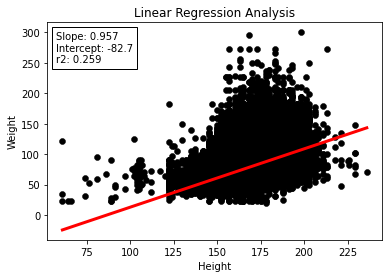

AttributeError: 'LeastSquares' object has no attribute 'confidence_interval'

In [101]:
df = LeastSquares(data)

df.lm_plot(title="Linear Regression Analysis"
          , xlabel="Height"
          , ylabel="Weight")

dfun = DisFunction(data)

<br><br>

### Creating classes for Hypothesis Testing

In [5]:
class HypothesisTest(object):
    
    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        
    def PValue(self, iterations=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) for _ in range(iterations)]
        n = len(self.test_stats)
        self.test_vals, self.test_freq = np.unique(self.test_stats, return_counts=True)
        self.test_prob = self.test_freq / n
        self.test_cdf = np.cumsum(self.test_prob)
        count = sum(1 for x in self.test_stats if x >= self.actual)
        self.p_value = count / iterations
        return self.p_value
    
    def PlotCDF(self, title=None, xlabel=None, ylabel='CDF'):
        cdf_plot = sns.lineplot(x=self.test_vals, y=self.test_cdf)
        ax = plt.gca()
        xmin, xmax, ymin, ymax = plt.axis()
        plt.vlines(x=self.actual, ymin=0, ymax=1, colors='red', alpha=.6)
        plt.title(title)
        box = AnchoredOffsetbox(child=TextArea(f'p-value: {self.p_value}'), loc='lower right' ,frameon=True)
        box.patch.set_boxstyle('square,pad=0')
        ax.add_artist(box)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        return cdf_plot
    
    def TestStatistic(self, data):
        pass
    
    def MakeModel(self):
        pass
        
    def RunModel(self):
        pass



class CointTest(HypothesisTest):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)  # call out inheritance of __init__ method from parent class
    
    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat
    
    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample_dict = {}
        
        for _ in range(n):
            key = random.choice(['H','T'])  # randomly choose 'H' & 'T'. n determined by data
            if key in sample_dict.keys():
                sample_dict[key] += 1
            else:
                sample_dict[key] = 1
                
        data = sample_dict['H'], sample_dict['T']
        return data
    
    
    
class DiffMeansPermute(HypothesisTest):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)  # call out inheritance of __init__ method from parent class
        
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())  # testing whether there is any difference
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n1, self.n2 = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))  # horizontally stack data into 1 array    
        
    def RunModel(self):
        np.random.shuffle(self.pool)  # randomly shuffle array
        data = self.pool[:self.n1], self.pool[self.n2:]
        return data
    
    
    
class DiffMeansOneSided(DiffMeansPermute):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat
    
    

class DiffStdPermute(DiffMeansPermute):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat
    
    
    
class CorrelationPermute(HypothesisTest):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)
        
    def TestStatistic(self, data):
        x, y = data
        test_stat = abs(sp.stats.pearsonr(x, y)[0])
        return test_stat
    
    def RunModel(self):
        x, y = self.data
        x = np.random.permutation(x)
        return x, y
    


class DiceTest(HypothesisTest):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)
        
        
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n/6
        test_stat = sum(abs(observed-expected))
        return test_stat
    
    
    def RunModel(self):
        n = sum(self.data)
        values = [1,2,3,4,5,6]
        rolls = np.random.choice(values, n, replace=True)
        val, count = np.unique(rolls, return_counts=True)
        return count
    
    
    
class DiceChiTest(DiceTest):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)
            
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n/6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat
    
    
class SlopeTest(HypothesisTest):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

Downey, Allen B.. Think Stats: Exploratory Data Analysis (p. 172). O'Reilly Media. Kindle Edition. 

<br><br>

<span style="font-size:18px"><b>Coin Flip p-value</b></span>

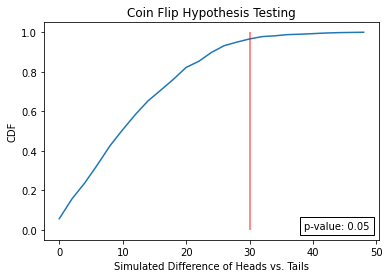

In [6]:
ct = CointTest((140,110))
ct.PValue(iterations=1000)
ct.PlotCDF(title='Coin Flip Hypothesis Testing'
          ,xlabel='Simulated Difference of Heads vs. Tails')

plt.show()

<br><br>

<span style="font-size:18px"><b>Permutation Testing</b></span>

- Mean Gestational Period for Firstborns vs. Non-Firstborn (2-Tailed)
- Mean Gestational Period for Firstborns vs. Non-Firstborn (1-Tailed)
- Mean Birth Weight for Firstborns vs. Non-Firstborn (2-Tailed)
- Mean Birth Weight for Firstborns vs. Non-Firstborn (2-Tailed)

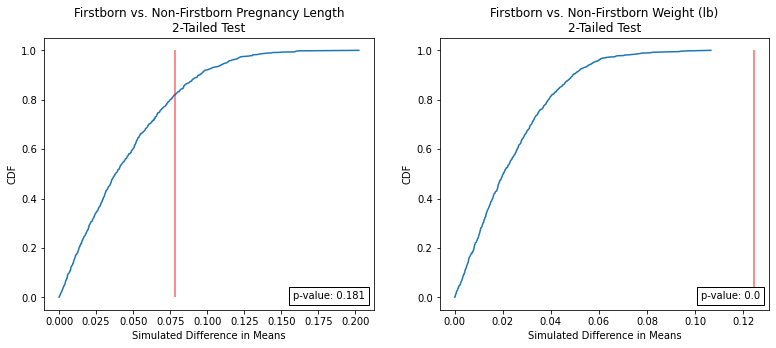

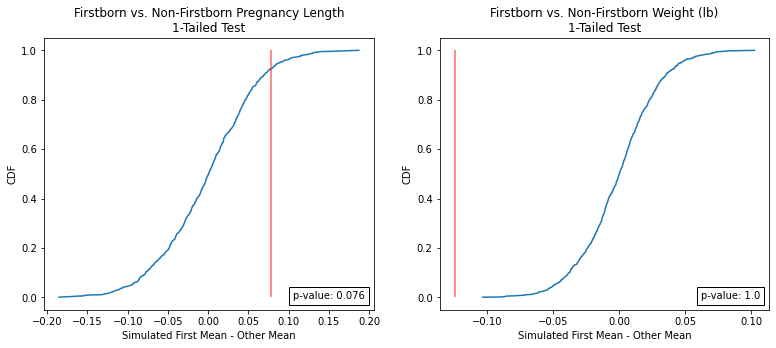

In [7]:
iterations = 1000


## create groups to form hypothesis testing on
length_data = firsts.prglngth.values, others.prglngth.values
weight_data = firsts.dropna(subset=['totalwgt_lb']).totalwgt_lb.values, others.dropna(subset=['totalwgt_lb']).totalwgt_lb.values


## length 2-tail
len_hyp_test_2tail = DiffMeansPermute(length_data)
len_hyp_test_2tail.PValue(iterations=iterations)

## length 1-tail
len_hyp_test_1tail = DiffMeansOneSided(length_data)
len_hyp_test_1tail.PValue(iterations=iterations)


## weight 2-tail
weight_hyp_test_2tail = DiffMeansPermute(weight_data)
weight_hyp_test_2tail.PValue(iterations=iterations)

## weight 1-tail
weight_hyp_test_1tail = DiffMeansOneSided(weight_data)
weight_hyp_test_1tail.PValue(iterations=iterations)



## plotting the CDF of the tests
plt.figure(figsize=(13,5))
plt.subplot(121)
len_hyp_test_2tail.PlotCDF(title='Firstborn vs. Non-Firstborn Pregnancy Length\n2-Tailed Test'
                    ,xlabel='Simulated Difference in Means')
plt.subplot(122)
weight_hyp_test_2tail.PlotCDF(title='Firstborn vs. Non-Firstborn Weight (lb)\n2-Tailed Test'
                       ,xlabel='Simulated Difference in Means')
plt.show()


plt.figure(figsize=(13,5))
plt.subplot(121)
len_hyp_test_1tail.PlotCDF(title='Firstborn vs. Non-Firstborn Pregnancy Length\n1-Tailed Test'
                    ,xlabel='Simulated First Mean - Other Mean')
plt.subplot(122)
weight_hyp_test_1tail.PlotCDF(title='Firstborn vs. Non-Firstborn Weight (lb)\n1-Tailed Test'
                       ,xlabel='Simulated First Mean - Other Mean')

plt.show()



<br><br>

Std.Deviation for Gestational Period for Firstborns vs. Non-Firstborn (1-Tailed)

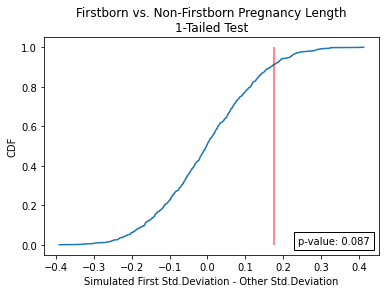

In [8]:
iterations=1000
length_data = firsts.prglngth.values, others.prglngth.values

len_std_hyp_test = DiffStdPermute(length_data)
len_std_hyp_test.PValue(iterations=iterations)

len_std_hyp_test.PlotCDF(title='Firstborn vs. Non-Firstborn Pregnancy Length\n1-Tailed Test'
                        , xlabel='Simulated First Std.Deviation - Other Std.Deviation')

plt.show()

<br><br>

Pearson's Correlation for Mother Age vs. Birth Weight (2-Tailed)

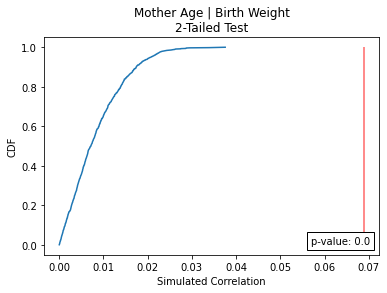

In [9]:
iterations=1000

live_clean = live.dropna(subset=['agepreg','totalwgt_lb'])
data = live_clean.agepreg.values, live_clean.totalwgt_lb.values
ht = CorrelationPermute(data)

ht.PValue(iterations=iterations)
ht.PlotCDF(title="Mother Age | Birth Weight\n2-Tailed Test"
          ,xlabel="Simulated Correlation")

plt.show()

<br><br>

<span style="font-size:18px">Proportion Testing vs. Chi Squared (more common)</span>

<u>Chi Squared Equation</u>: <br><br>
<span style="font-size:18px">$x^2=\sum{\frac{(O_i-E_i)^2}{E_i}}$</span>
$O_i=observed\ frequencies\\E_i=expected frequencies$

<br>

Chi Squared gives more weight to large deviations and dividing by the expected value for each frequency standardizes the value.

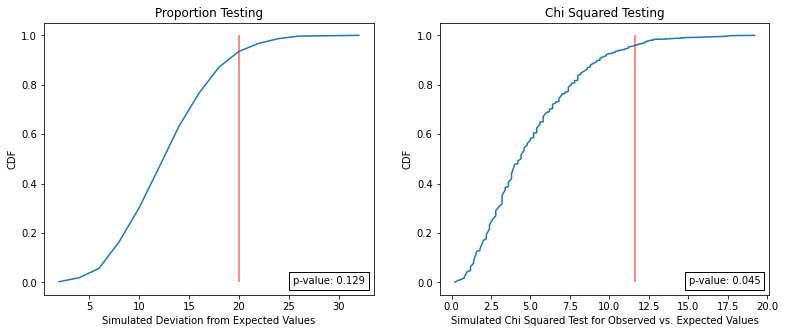

In [10]:
## observed number of times landed on dice (if fair should be the same for all 6 sides)
data = [8,9,19,5,8,11]

plt.figure(figsize=(13,5))

plt.subplot(121)
dt = DiceTest(data)
dt.PValue()
dt.PlotCDF(title="Proportion Testing"
          , xlabel="Simulated Deviation from Expected Values")

plt.subplot(122)
chi_dt = DiceChiTest(data)
chi_dt.PValue()
chi_dt.PlotCDF(title="Chi Squared Testing"
              , xlabel="Simulated Chi Squared Test for Observed vs. Expected Values")

plt.show()

<br><br>



In [11]:
class PregLengthTest(HypothesisTest):
    
    def __init__(self, data):
        HypothesisTest.__init__(self, data)
        
    def MakeModel(self):
        firsts, others = self.data
        self.firsts_n = len(firsts)
        self.others_n = len(others)
        self.pool = np.hstack((firsts, others))
        self.pool_n = self.pool.size
        self.rng = range(35, 44)
        self.vals, self.freqs = np.unique(self.pool, return_counts=True)
        self.probs = self.freqs / self.pool_n
        freq_dict = {}
        for _ in self.rng:
            freq_dict[_] = 0
            
        for i, val in enumerate(self.vals):
            if val in freq_dict.keys():
                freq_dict[val] = self.probs[i]
            else:
                pass
            
        self.expected_probs = np.fromiter(freq_dict.values(), dtype=float)
                 
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.firsts_n], self.pool[self.others_n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat
    
    def ChiSquared(self, data):
        vals, freq = np.unique(data, return_counts=True)
        freq_dict = {}
        for _ in self.rng:
            freq_dict[_] = 0
            
        for i, val in enumerate(vals):
            if val in freq_dict.keys():
                freq_dict[val] = freq[i]
            else:
                continue
        observed = np.fromiter(freq_dict.values(), dtype=float)
        expected = self.expected_probs * len(data)
        stat = sum((observed-expected)**2 / expected)
        return stat
        
        

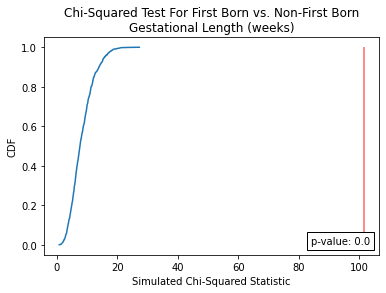

In [12]:
length_data2 = firsts.prglngth.values, others.prglngth.values

chi_sq = PregLengthTest(length_data2)
chi_sq.PValue()
chi_sq.PlotCDF(title="Chi-Squared Test For First Born vs. Non-First Born\nGestational Length (weeks)"
              ,xlabel="Simulated Chi-Squared Statistic")
plt.show()

<br><br>

<span style="font-size:18px"><b>Power</b></span>

Also known as sensitivity, power relects the ability of a test to detect an effect of a given size. It is the opposite of the false negative rate. For example if a test has a 70% false negative rate, the power of the test would be 30%. As a general rule of thumb, 80% power is considered acceptable.

In [13]:
def FalseNegativeRate(data, num_runs=100):
    group1, group2 = data
    count = 0
    
    for i in range(num_runs):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        
        ht = DiffMeansPermute((sample1, sample2))
        pvalue = ht.PValue(iterations=101)
        if pvalue > 0.05:
            count += 1
            
    return count / num_runs


data = firsts.prglngth.values, others.prglngth.values

neg_rate = FalseNegativeRate(data)

neg_rate

0.7

<br><br>

<span style="font-size:18px"><b>Linear Least Squares</b></span>

In [89]:
class LeastSquares(object):
    
    def __init__(self, data):
        self.data = data
        xs, ys = data
        xs, ys = np.asarray(xs), np.asarray(ys)
        sort_i = xs.argsort()
        self.xs = xs[sort_i]
        self.ys = ys[sort_i]
        self.mean_xs, self.var_xs = np.mean(self.xs), np.var(self.xs)
        self.mean_ys, self.var_ys = np.mean(self.ys), np.var(self.ys)
        self.cov = np.dot(self.xs-self.mean_xs, self.ys-self.mean_ys) / len(self.xs)
        self.slope = self.cov / self.var_xs  # slope is shared variance of x & y divided by variance in x
        self.intercept = self.mean_ys - (self.slope * self.mean_xs)

        ## residuals and predicted values
        self.predicted_values = self.intercept + (self.slope * self.xs)
        self.residuals = self.ys - self.predicted_values
        
    def coef_of_determ(self):
        coef_of_determ = 1 - ( np.var(self.residuals) / np.var(self.ys - self.mean_ys) )
        return coef_of_determ
        
    def lm_plot(self, title=None, xlabel=None, ylabel=None, alpha=1, linecolor='red', plotcolor='black'):
        self.lm_ys = []
        lm_xs = np.sort(self.xs)
        n = len(lm_xs)

        for x in lm_xs:
            y = (self.slope*x) + self.intercept
            self.lm_ys.append(y)

        sns.lineplot(x=lm_xs, y=self.predicted_values, linewidth=3, color=linecolor)
        sns.scatterplot(x=self.xs, y=self.ys, alpha=alpha, edgecolor=None, color=plotcolor)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        ax = plt.gca()
        box = AnchoredOffsetbox(child=TextArea(f'Slope: {round(self.slope,3)}\nIntercept: {round(self.intercept,1)}\nr2: {round(self.coef_of_determ(),3)}'), loc='upper left' ,frameon=True)
        box.patch.set_boxstyle('square,pad=0')
        ax.add_artist(box)
        plt.show()

In [15]:
live, firsts, others = first.MakeFrames()

live = live.dropna(subset=['agepreg','totalwgt_lb'])

ages = live.agepreg
weights = live.totalwgt_lb

<br>

Instantiating Linear Least Squares object

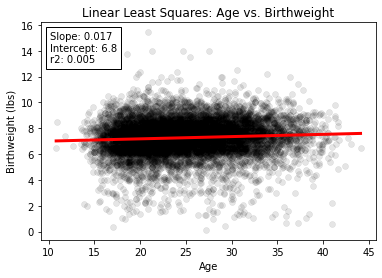

In [90]:
data = ages, weights

lm = LeastSquares(data)
lm.lm_plot(title="Linear Least Squares: Age vs. Birthweight"
           ,xlabel="Age"
           ,ylabel="Birthweight (lbs)"
           ,alpha=.1)

<br>

Plotting Residuals

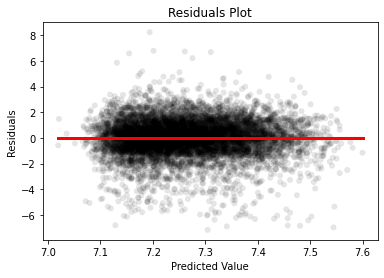

In [18]:
sns.regplot(x=lm.predicted_values, y=lm.residuals
            , scatter_kws={'color':'black','alpha':.1,'edgecolor':'None'}
            , line_kws={'linewidth':3,'color':'red'})
plt.title("Residuals Plot")
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.show()

In [69]:
class DisFunction(object):
    
    def __init__(self, data):
        self.data = np.asarray(data)
        self.size = self.data.size
        self.unique_vals, self.freq = np.unique(self.data, return_counts=True)
        self.pmf = self.freq / self.size
        self.cdf = np.cumsum(self.pmf)
        self.mean = sum(self.data) / self.size
        self.std = np.std(data)
        
    def percentile(self, percentile, method='inverted_cdf'):
        return np.percentile(self.data, percentile, method=method)
    
    def confidence_interval(self, alpha=.95, dof=1):
        ci = sp.stats.t.interval(alpha=alpha, df=self.size-dof, loc=self.mean, scale=self.std)
        return ci



In [72]:
def SamplingDistributions(live, iters=101):
    test_stats = {
        "simulated intercepts": []
        , "simulated slopes": []
    }
    n = len(live)
    for _ in range(iters):
        indices = np.random.choice(live.index, n, replace=True)
        sample = live.loc[indices]
        data = sample.agepreg, sample.totalwgt_lb
        estimates = LeastSquares(data)
        test_stats["simulated intercepts"].append(estimates.intercept)
        test_stats["simulated slopes"].append(estimates.slope)
        
    return test_stats

stats_dict = SamplingDistributions(live)


In [79]:
df_inter = DisFunction(stats_dict["simulated intercepts"])
df_slope = DisFunction(stats_dict["simulated slopes"])

print(f"""INTERCEPTS
mean: {df_inter.mean}
std.error: {df_inter.std}
90% ci: {df_inter.confidence_interval(alpha=.90)}

SLOPES
mean: {df_slope.mean}
std.error: {df_slope.std}
90% ci: {df_slope.confidence_interval(alpha=.90)}""")

INTERCEPTS
mean: 6.834478230956532
std.error: 0.06872434249720444
90% ci: (6.720379718506374, 6.94857674340669)

SLOPES
mean: 0.017279165390917114
std.error: 0.002674306002943297
90% ci: (0.012839190766426957, 0.021719140015407267)
